In [1]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import defaultdict

def visualize_partitions(mode="unfiltered"):
    base_root = "app/temp"
    base_dir = os.path.join(base_root, mode)

    # Load free variables
    free_vars_path = os.path.join(base_root, "free_vars.json")
    with open(free_vars_path, 'r') as f:
        free_vars = set(json.load(f))
    print(f"Loaded free variables: {free_vars}")

    # Load partition files
    files = sorted(
        [f for f in os.listdir(base_dir) if f.startswith("partition_") and f.endswith(".json")],
        key=lambda x: int(x.split('_')[1].split('.')[0])
    )

    print(f"Found {len(files)} partitions in '{mode}'")

    for path in files:
        print(f"\nReading {path}...")
        with open(os.path.join(base_dir, path), 'r') as file:
            data = json.load(file)

        G = nx.DiGraph()
        edge_component = {}
        edge_labels = {}
        node_to_components = defaultdict(set)
        components = defaultdict(list)
        component_nodes = defaultdict(set)

        for edge in sorted(data, key=lambda e: (e['source'], e['label'], e['target'])):
            src, tgt, label = edge['source'], edge['target'], edge['label']
            comp_id = int(edge['component'])

            G.add_edge(src, tgt, label=label)
            edge_component[(src, tgt)] = comp_id
            edge_labels[(src, tgt)] = label

            node_to_components[src].add(comp_id)
            node_to_components[tgt].add(comp_id)
            components[comp_id].append((src, label, tgt))
            component_nodes[comp_id].update([src, tgt])

        # Global join nodes
        join_nodes = {n for n, comps in node_to_components.items() if len(comps) > 1 or n in free_vars}

        # Edge and node colors
        unique_components = sorted(components.keys())
        cmap = cm.get_cmap('tab10', len(unique_components))
        norm = mcolors.Normalize(vmin=0, vmax=len(unique_components) - 1)
        edge_colors = [cmap(norm(edge_component[e])) for e in G.edges]
        node_colors = ["red" if n in join_nodes else "lightgray" for n in G.nodes]

        # Plot
        plt.figure(figsize=(10, 7))
        pos = nx.kamada_kawai_layout(G, weight=None)
        pos = {n: pos[n] for n in sorted(G.nodes())}

        nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
        nx.draw_networkx_edges(G, pos, arrows=True, edge_color=edge_colors)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # Compose annotation text per component
        comp_text_lines = []
        for cid in sorted(components):
            edges = components[cid]
            jn_in_comp = sorted(n for n in component_nodes[cid] if n in join_nodes)
            edge_repr = ", ".join(f"{src} -{label}-> {tgt}" for src, label, tgt in edges)
            comp_text_lines.append(f"Component {cid}:\n  Edges: {edge_repr}\n  Join Nodes: {', '.join(jn_in_comp) or 'None'}")

        annotation_text = "\n\n".join(comp_text_lines)

        plt.gcf().text(0.02, 0.98, annotation_text, fontsize=9, verticalalignment='top', family='monospace')
        plt.title(f"Partition: {path}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


Loaded free variables: {'A'}
Found 11 partitions in 'cpq'

Reading partition_1.json...


/tmp/ipykernel_153325/329553802.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_components))


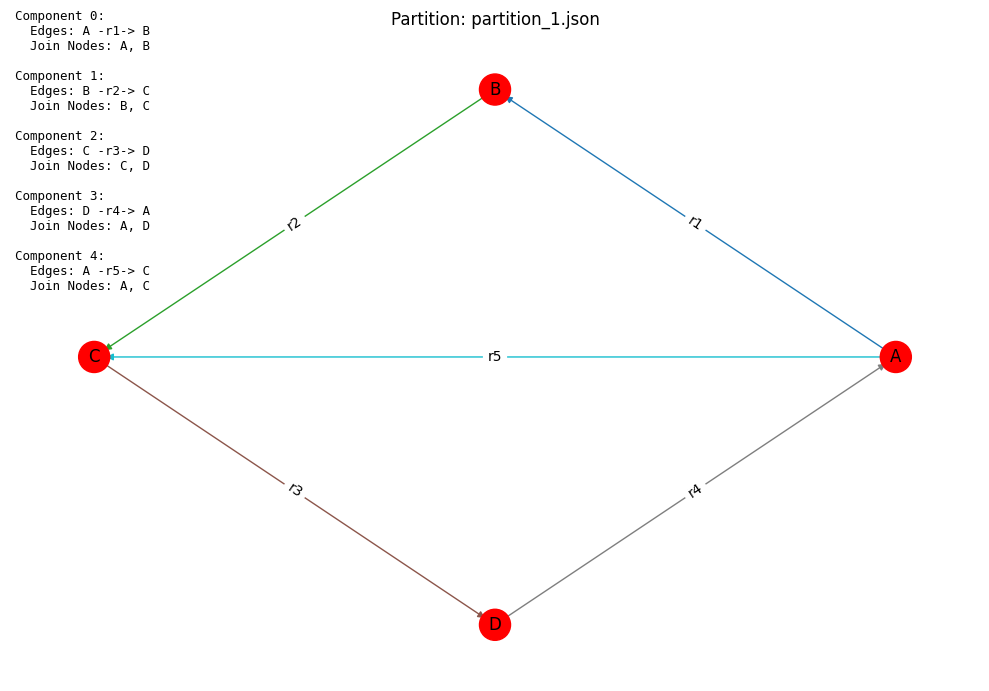


Reading partition_2.json...


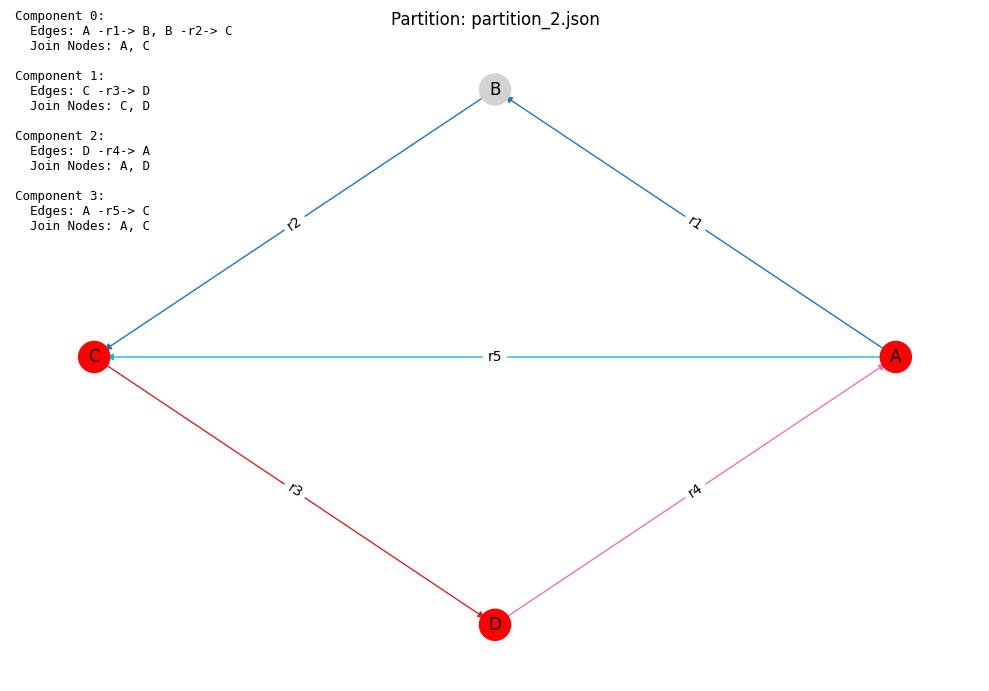


Reading partition_3.json...


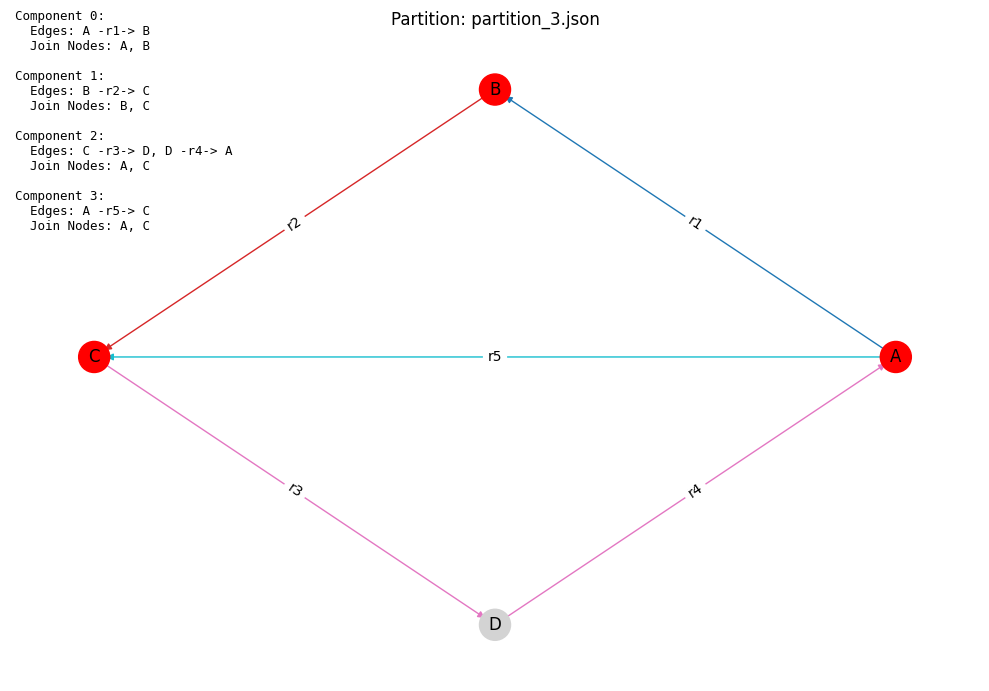


Reading partition_4.json...


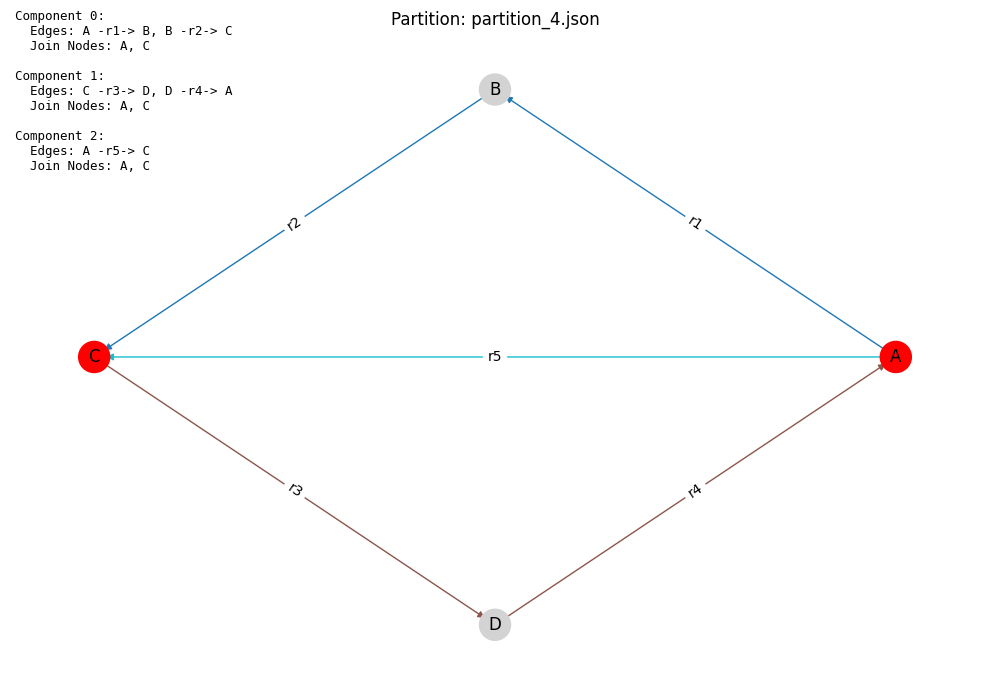


Reading partition_5.json...


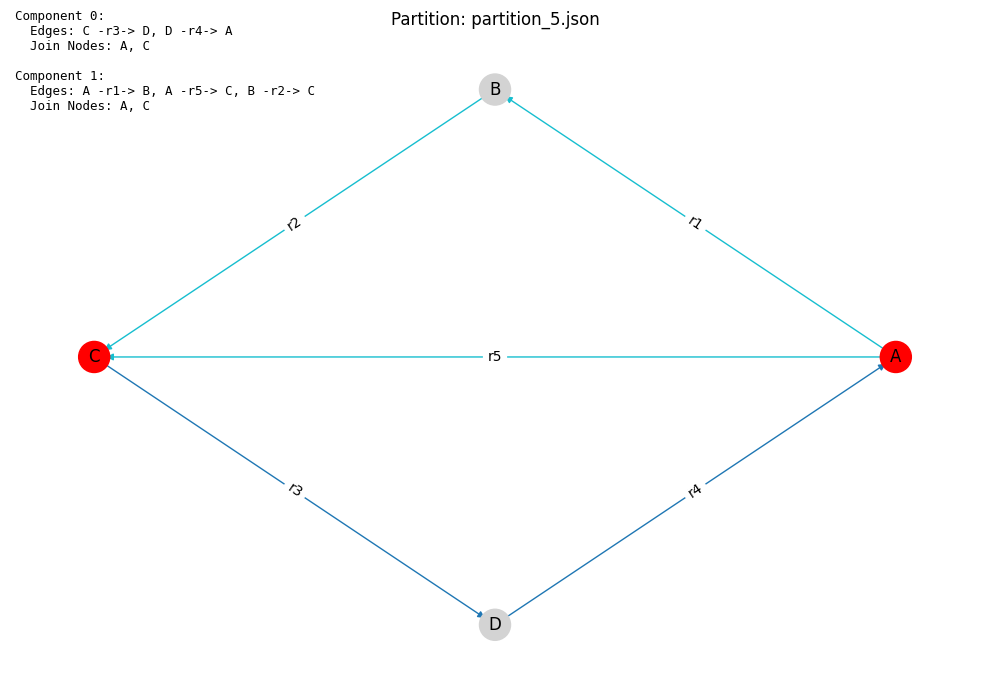


Reading partition_6.json...


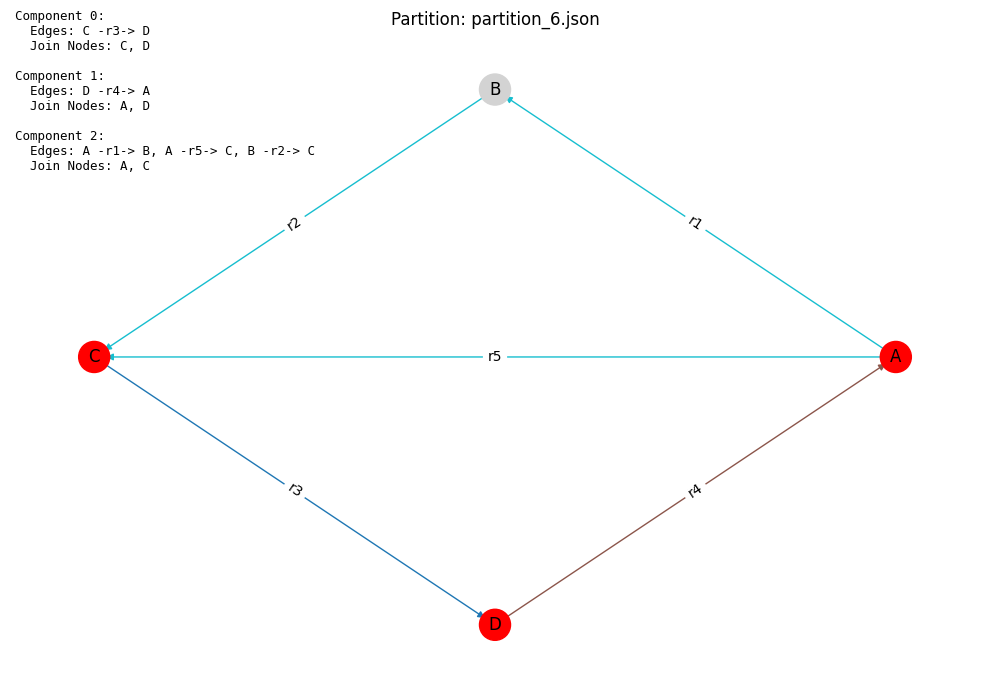


Reading partition_7.json...


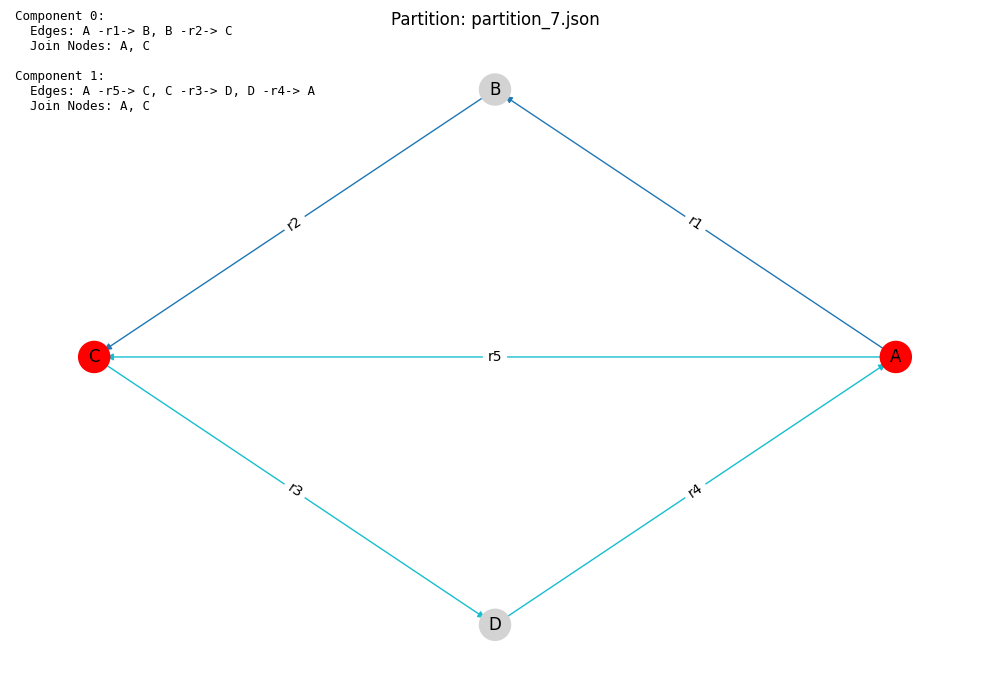


Reading partition_8.json...


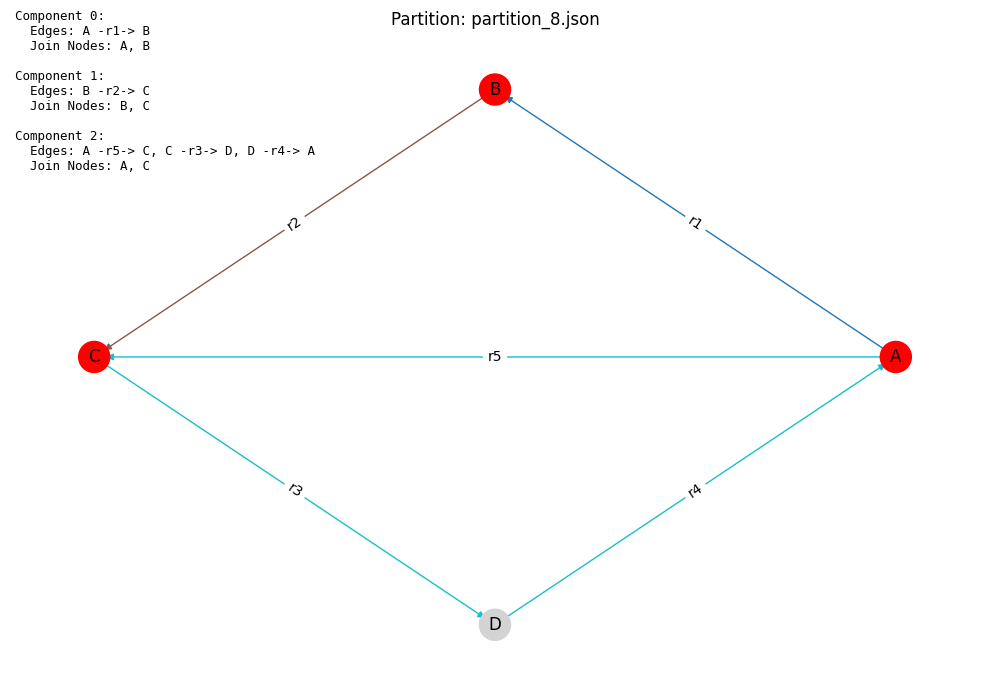


Reading partition_9.json...


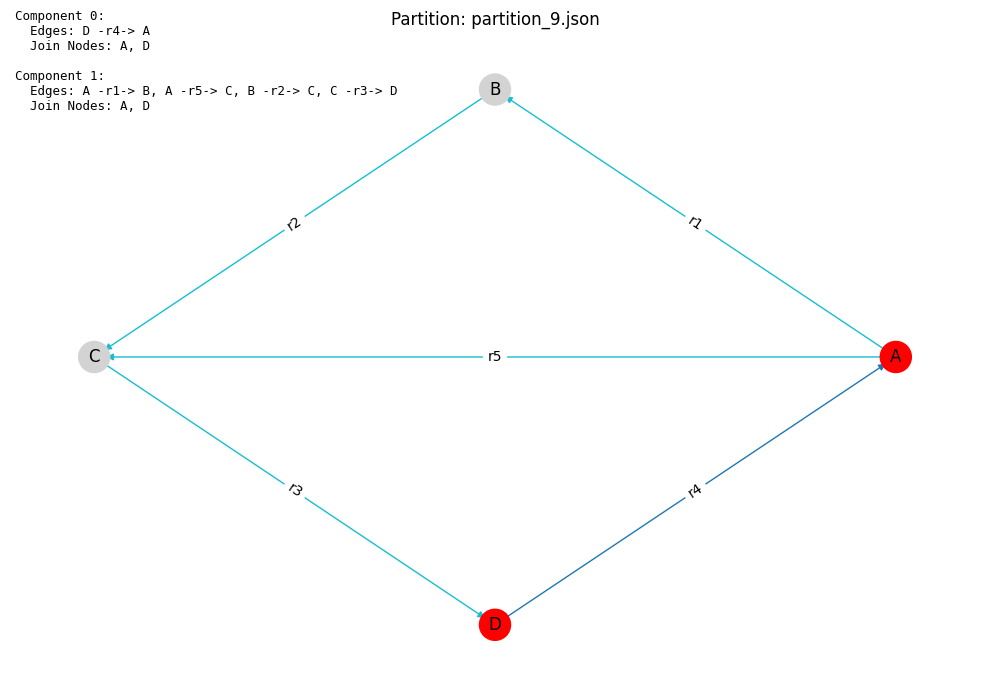


Reading partition_10.json...


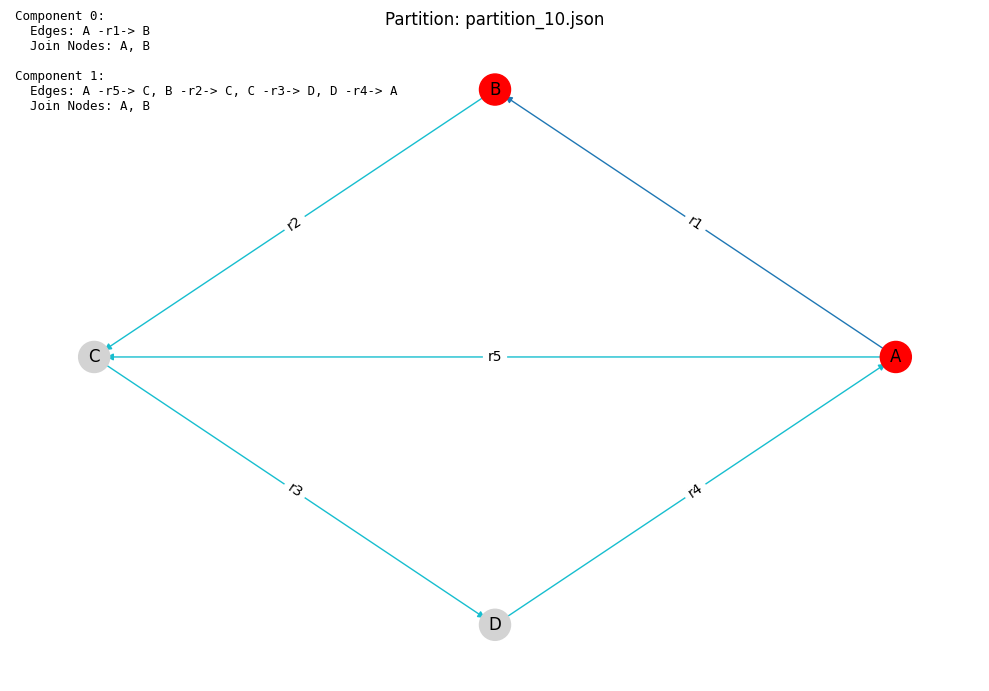


Reading partition_11.json...


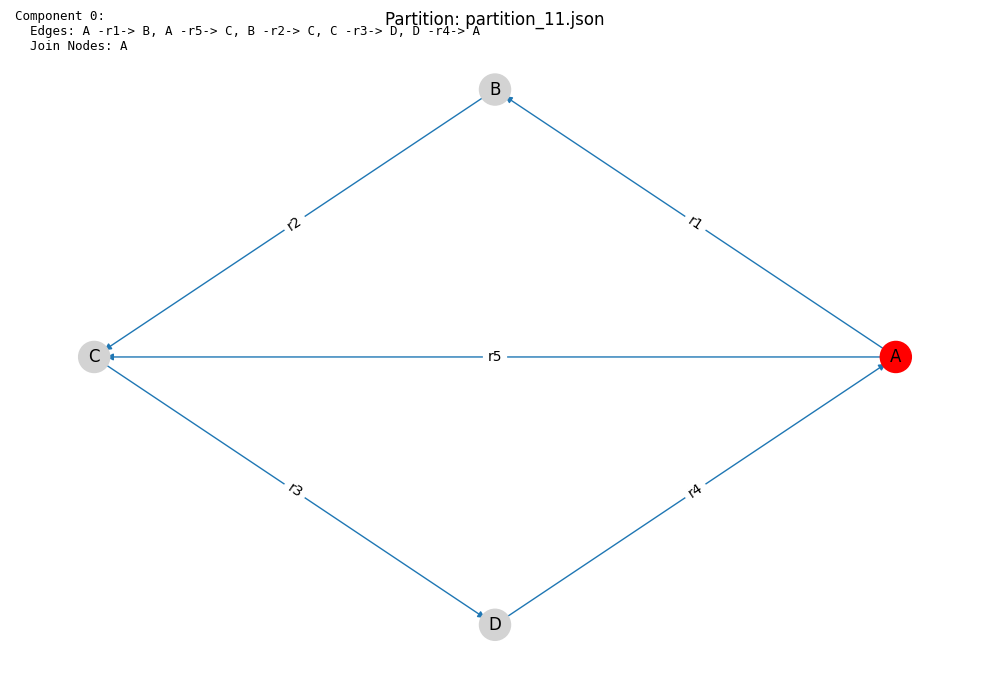

In [3]:
visualize_partitions("cpq")